In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy
from scipy.optimize import curve_fit

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N+1])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=hospitalCases&metric=covidOccupiedMVBeds&format=json"
geographical_context = "England"

In [4]:
# Regions
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&metric=hospitalCases&metric=covidOccupiedMVBeds&format=json&format=json"
#geographical_context = 'North West'
#geographical_context = 'North East and Yorkshire'
#geographical_context = 'Midlands'
geographical_context = 'London'
#geographical_context = 'East of England'
#geographical_context = 'South East'
#geographical_context = 'South West'


In [5]:
# download api data
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df_withna = df.copy()
df.dropna(inplace=True)

top_date = sorted(list(set(df.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

in_event = "hospital admission"
out_event = "hospital occupancy"

2022-02-08


In [6]:
train_start_date = "2021-09-01" 
train_end_date = "2021-12-01"
test_start_date = "2021-10-01"
test_end_date = top_date

train_start_date = datetime.datetime.strptime(train_start_date, "%Y-%m-%d")
train_end_date = datetime.datetime.strptime(train_end_date, "%Y-%m-%d")
test_start_date = datetime.datetime.strptime(test_start_date, "%Y-%m-%d")

In [7]:
# set data
_df = df[df.areaName==geographical_context]    
train_df = _df[(_df.dateTime >= train_start_date) & (_df.dateTime <= train_end_date)]
test_df = _df[(_df.dateTime >= test_start_date) & (_df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.hospitalCases.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.hospitalCases.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

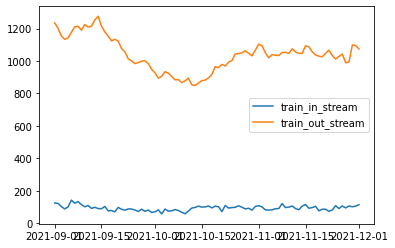

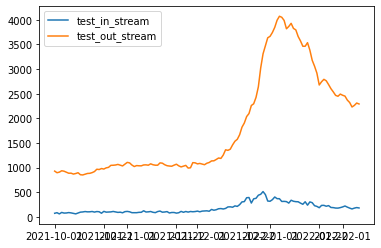

In [8]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [9]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with cumsumflip(x)
    target_out_stream = out_stream[len(x)-1:]
    _x = cumsumflip(x)
    pred_out_stream = np.convolve(in_stream, _x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [10]:
n_dim = 35
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.5, 'c2': 0.1, 'w': 0.65}
bounds = (x_min, x_max)
init_pos = None #np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(10):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 500, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2022-02-10 23:43:16,972 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.1, 'w': 0.65}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=18.7
2022-02-10 23:43:20,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.710914909526508, best pos: [ 0.01590287  0.0471463   0.03239247  0.00720113  0.04142044  0.02585989
  0.0532506   0.02631825  0.02063874  0.02185095  0.02123477  0.05719697
  0.02112277  0.04680733  0.01806978  0.03147438  0.02591555  0.02791912
  0.00906931  0.01871229  0.01318055  0.0065545   0.01820211  0.05717653
  0.01531093  0.02037429  0.03183598  0.0246362  -0.00048974  0.00946595
  0.00498664  0.00585549  0.00272627 -0.00122037  0.00213637]
2022-02-10 23:43:20,336 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.1, 'w': 0.65}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=18.4
2022-02-10 23:43:23,725 - pyswarms.single.global_best - I

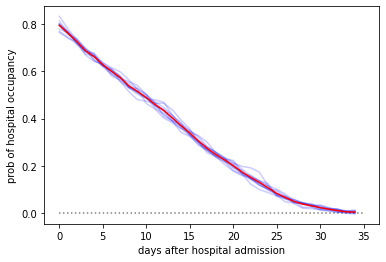

<Figure size 432x288 with 0 Axes>

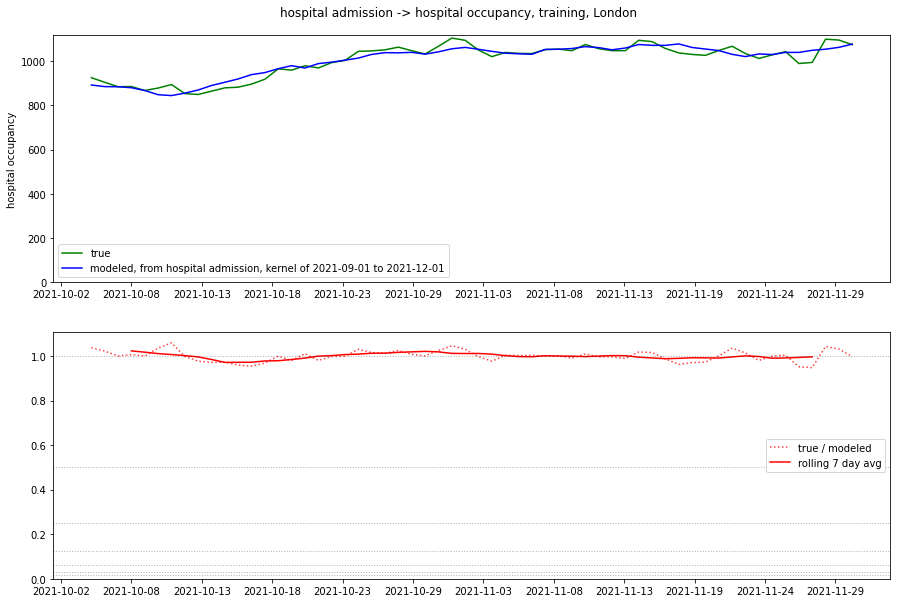

<Figure size 432x288 with 0 Axes>

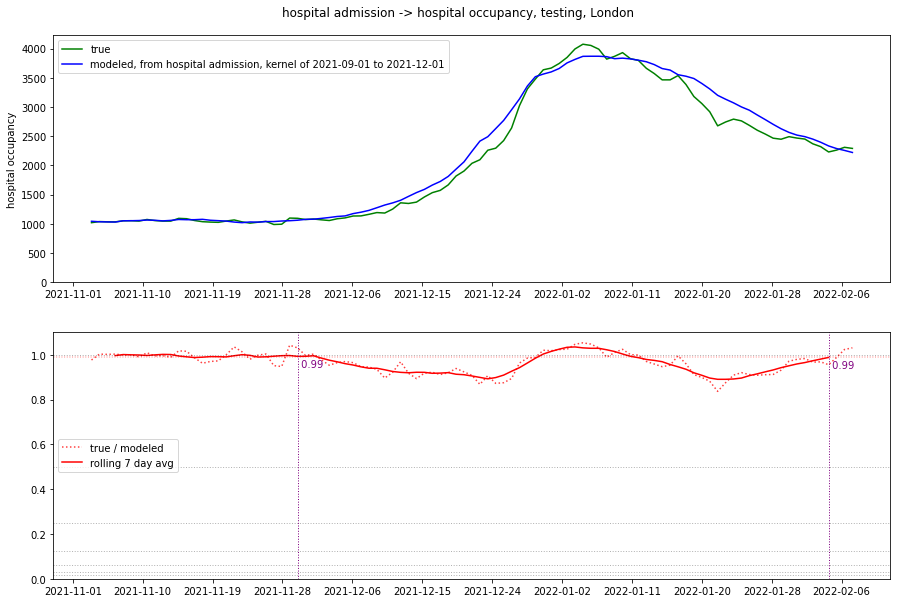

In [11]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, cumsumflip(y), color="blue", alpha=0.2)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
plt.plot(z, cumsumflip(avg_minimizer), color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("prob of %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
plt.savefig("%s__%s__kernel.png" % (in_event, out_event), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

def log2(a):
    return math.log2(a) if a>0 else math.log2(-a) if a<0 else 0

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train, allow_scaling=False):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _g(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    test_scale_factor = 1
    final_scale_factor = None
    if test_train=="test":
        if allow_scaling:
            test_scale_factor = avg_diff[np.isfinite(avg_diff)][0]
        pred *= test_scale_factor
        diff /= test_scale_factor
        avg_diff = N_avg_hard(diff, 3)
        final_scale_factor = avg_diff[np.isfinite(avg_diff)][-1]
        comp_idx = dates.index(datetime.datetime(year=2021,month=12,day=1))
        comp_idx = len(dates) - comp_idx + 1
        comp_scale = avg_diff[np.isfinite(avg_diff)][-comp_idx]
        
    ax1.plot(x, true, color="green", label="true")
    modeled_label = "modeled, from %s, kernel of %s to %s" % (in_event, train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"))
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.set_ylim(0,None)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff, color="red", alpha=0.75, ls="dotted", label="true / modeled") # unscaled
    ax2.plot(x, avg_diff, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        if allow_scaling:
            ax2.axvline(x=x[3], color="black", ls="dotted")
            ax1.axvline(x=x[3], color="black", ls="dotted")
            y_min,y_max = ax1.get_ylim()
            y_mid = (y_min+y_max)/2 
            ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), test_scale_factor), ha="left")
        ax2.axhline(y=final_scale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], final_scale_factor-0.05, " %.2f" % (final_scale_factor), ha="left", color="purple")    
        ax2.axvline(x=x[-4], color="purple", ls="dotted", lw=1)
        ax2.axhline(y=comp_scale, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-comp_idx], comp_scale-0.05, " %.2f" % (comp_scale), ha="left", color="purple")    
        ax2.axvline(x=x[-comp_idx], color="purple", ls="dotted", lw=1) 
    
    fig.suptitle("%s -> %s, %sing, %s" % (in_event, out_event, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    return test_scale_factor, final_scale_factor
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
test_scale_factor, final_scale_factor = make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 


In [12]:
def format_minimizer(a):
    s = ",".join(["%.6f"%x for x in a])
    print(s)
    
format_minimizer(avg_minimizer)

0.034168,0.034747,0.039675,0.024997,0.034050,0.027708,0.027057,0.034924,0.023727,0.026033,0.029134,0.025257,0.031956,0.033141,0.030805,0.033923,0.031469,0.025959,0.022778,0.024431,0.026947,0.022315,0.021694,0.022949,0.023992,0.017404,0.016487,0.011488,0.006801,0.008165,0.006421,0.005798,0.005314,0.000689,0.003610


[ 1.41270058e-01  1.03646749e-04 -1.51662872e-01  9.23331180e+01]


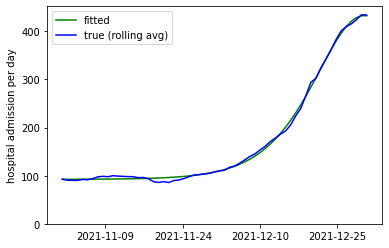

<Figure size 432x288 with 0 Axes>

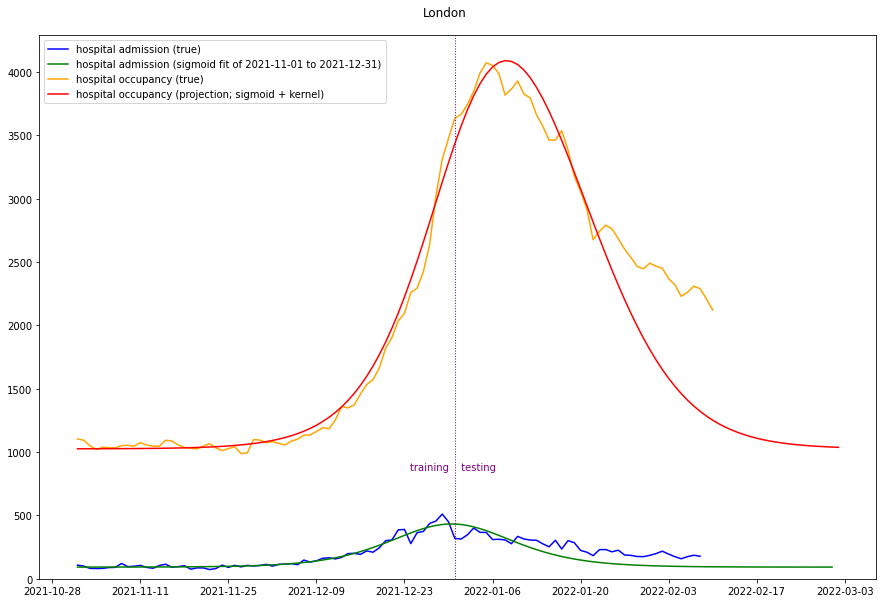

In [13]:
# back of envelope prediction:
# fit admissions to D(sigmoid) + const
# use that + kernel + scale factors to "predict" future occupancy

sigmoid_geographical_context = geographical_context
#sigmoid_geographical_context = 'England'
#sigmoid_geographical_context = 'North West'
#sigmoid_geographical_context = 'North East and Yorkshire'
#sigmoid_geographical_context = 'Midlands'
#sigmoid_geographical_context = 'London'
#sigmoid_geographical_context = 'East of England'
#sigmoid_geographical_context = 'South East'
#sigmoid_geographical_context = 'South West'

sigmoid_train_start_date = datetime.datetime(year=2021, month=11, day=1)
sigmoid_train_end_date = datetime.datetime(year=2021, month=12, day=31) 

_df = df[df.areaName==sigmoid_geographical_context]    
sigmoid_train_df = _df[(_df.dateTime >= sigmoid_train_start_date) & (_df.dateTime <= sigmoid_train_end_date)]
sigmoid_train_stream = np.array(sigmoid_train_df.newAdmissions.to_list(), dtype=float)
sigmoid_dates_train = sorted(list(set(sigmoid_train_df.dateTime.to_list())))

def Dsigmoid(x, a, b, c, d):
    return d + a * np.exp(-c*x) * np.reciprocal((1+b*np.exp(-c*x))**2)

sigmoid_fit = N_avg_soft(sigmoid_train_stream,3)
sigmoid_x_range_train = list(range(1,len(sigmoid_fit)+1))
max_base = 2000 if sigmoid_geographical_context=="England" else 200
bounds = ([0,-.5,-.5,0],[100,.5,.5,max_base])
params, covars = curve_fit(Dsigmoid, sigmoid_x_range_train, sigmoid_fit, method="trf", bounds=bounds, maxfev=50000)#, loss="soft_l1")
print(params)

plt.clf()
ys = [Dsigmoid(x,*params) for x in sigmoid_x_range_train]
plt.plot(sigmoid_dates_train, ys, label="fitted", color="green")
plt.plot(sigmoid_dates_train, sigmoid_fit, label="true (rolling avg)", color="blue")
plt.ylabel("%s per day" % in_event)
plt.ylim(0,None)
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(len(sigmoid_x_range_train)/4))
plt.savefig("%s__%s__%s__amateurish_prediction_training.png" % (in_event, out_event, sigmoid_geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

def plt_clipped(ax, start_date, x, y, label="", color="red"):
    x = np.array(x)
    y = np.array(y)
    _x = x[x >= start_date]
    _y = y[x >= start_date]
    ax.plot(_x,_y, label=label, color=color)

sigmoid_display_start_date = sigmoid_train_start_date
sigmoid_display_end_date = datetime.datetime(year=2022, month=3, day=1)
sigmoid_display_dates = pd.date_range(sigmoid_display_start_date, sigmoid_display_end_date).to_list()

_df = df_withna[df_withna.areaName==sigmoid_geographical_context]
_df = _df[(_df.dateTime >= sigmoid_display_start_date) & (_df.dateTime <= sigmoid_display_end_date)]

admiss_df = _df[["dateTime","newAdmissions"]]
sigmoid_admiss_dates = admiss_df.dateTime.to_list()
sigmoid_admiss = admiss_df.newAdmissions.to_list()

occup_df = _df[["dateTime","hospitalCases"]]
sigmoid_occup_dates = occup_df.dateTime.to_list()
sigmoid_occup = occup_df.hospitalCases.to_list()

sigmoid_x_range = list(range(1-len(avg_minimizer),1+len(sigmoid_display_dates)))
sigmoid_vals = [Dsigmoid(x,*params) for x in sigmoid_x_range]
sigmoid_vals_dates = pd.date_range(sigmoid_display_start_date - datetime.timedelta(days=len(avg_minimizer)), sigmoid_display_end_date)

kernel = cumsumflip(avg_minimizer)#*test_scale_factor*final_scale_factor
sigmoid_preds = np.convolve(sigmoid_vals, kernel, mode="valid")
sigmoid_preds_dates = pd.date_range(sigmoid_display_start_date, sigmoid_display_end_date+datetime.timedelta(days=1))

clip_date = sigmoid_dates_train[0]# - datetime.timedelta(days=5)

plt.clf()
fig, ax1 = plt.subplots(1,1, figsize=(15,10))
plt_clipped(ax1, clip_date, sigmoid_admiss_dates, sigmoid_admiss, label="%s (true)" % in_event, color="blue")
plt_clipped(ax1, clip_date, sigmoid_vals_dates, sigmoid_vals, label="%s (sigmoid fit of %s to %s)" % (in_event, sigmoid_train_start_date.strftime("%Y-%m-%d"), sigmoid_train_end_date.strftime("%Y-%m-%d")), color="green")
plt_clipped(ax1, clip_date, sigmoid_occup_dates, sigmoid_occup, label="%s (true)" % out_event, color="orange")
plt_clipped(ax1, clip_date, sigmoid_preds_dates, sigmoid_preds, label="%s (projection; sigmoid + kernel)" % out_event, color="red")
ax1.xaxis.set_major_locator(ticker.MultipleLocator(14))
ax1.legend()
ax1.set_ylim(0,None)
ax1.axvline(x=sigmoid_train_end_date, color="purple", ls="dotted", lw=1)
_,y_max = ax1.get_ylim()
ax1.text(sigmoid_train_end_date, 0.2*y_max, "training  ", color="purple", ha="right")
ax1.text(sigmoid_train_end_date, 0.2*y_max, "  testing", color="purple", ha="left")
plt.suptitle("%s" % sigmoid_geographical_context, y=0.92)
plt.savefig("%s__%s__%s__amateurish_prediction.png" % (in_event, out_event, sigmoid_geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()
